# Reproducing Figures and Tables

In [1]:
from __future__ import print_function, absolute_import, division
import sys, os, json, requests, time, datetime, logging, pickle
from pathlib import Path
import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model
import tqdm
import wandb
from matplotlib import pyplot as plt


import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt


sns.set()
sns.set(font_scale=2.5,)
sns.set_style("white")
# sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette("colorblind")


plt.rcParams.update({'font.size': 20, 'lines.linewidth':4, 'lines.markersize':12, 
                         'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':20,
                         'axes.titlesize': 20, 'legend.fontsize':20,
                         'pdf.fonttype': 42, 'ps.fonttype':42,
                        'image.interpolation':'nearest', 'figure.figsize': (10,8),
                     'text.usetex': False
                     
                    })
tqdm.tqdm.pandas()
# logging.getLogger().setLevel(logging.CRITICAL)

Table utility functions

In [53]:
def show_table(df, gg_method = 'min'):
    df = df.reset_index(drop=True)
    return pd.concat([
    (df
      .query("constraint=='eo'")
     .assign(run_count=lambda x:x['exp_name'], grid_count=lambda x:x['grid'])
     .groupby(["constraint", "violation_eps", "loss_type", ])
     .agg({
         'test_balloss_cls_eo': agg_method,
              'run_count': 'nunique',
         'grid_count': 'nunique',
     })
    ),
    (df
      .query("constraint=='dp'")
     .assign(run_count=lambda x:x['exp_name'], grid_count=lambda x:x['grid'])
     .groupby(["constraint", "violation_eps", "loss_type", ])
     .agg({
         'test_balloss_cls_dp': agg_method,
         'run_count': 'nunique',
         'grid_count': 'nunique',
     })
    )
        ], axis=1)

def show_agg_df(df, gg_method = 'min',
                added_cols=["train_acc", "test_acc"],
                group_cols=["constraint","violation_eps", "loss_type", "use_drw"]):
    df = df.reset_index(drop=True)
    eo_df = (df.query("constraint=='eo'")
     .assign(run_count=lambda x:x['exp_name'], grid_count=lambda x:x['grid'])
     .reset_index(drop=True)
     .rename({'test_balloss_cls_eo': 'test_balanced_loss',
              'train_balloss_cls_eo': 'train_balanced_loss',
              'test_eo': 'test_violation',
              'train_eo': 'train_violation'
             },axis=1)
    )
    dp_df = (df.query("constraint=='dp'")
     .assign(run_count=lambda x:x['exp_name'], grid_count=lambda x:x['grid'])
     .reset_index(drop=True)
     .rename({'test_balloss_cls_dp': 'test_balanced_loss',
              'train_balloss_cls_dp': 'train_balanced_loss',
              'test_dp': 'test_violation',
              'train_dp': 'train_violation'
             },axis=1)
    )
    df = pd.concat([eo_df, dp_df]).reset_index(drop=True)

    return (df
     .iloc[df.groupby(group_cols)['test_balanced_loss'].idxmin()]
     [group_cols+added_cols+[
       "test_balanced_loss","train_balanced_loss",
       "test_violation", "train_violation", 
       "test_cls_avg_acc", "train_cls_avg_acc", 
        
      ]]
    .reset_index(drop=True)
    .assign(bal_acc_gap=lambda x :  x['train_cls_avg_acc'] - x['test_cls_avg_acc'] )
    .assign(bal_loss_gap=lambda x :  x['test_balanced_loss'] - x['train_balanced_loss'] )
    .assign(violation_gap=lambda x :  x['test_violation'] - x['train_violation'] )
    ).groupby(group_cols).first()
    

# Load Data

In [1112]:
def process_table(table, method_suffix='-GS', tuple_header=None, use_drw=None, show_gap=False, constraint='eo'):
    if use_drw is not None:
        table = table.query(f'use_drw=={use_drw}')
    table = (show_agg_df(table, group_cols=["constraint","violation_eps", "loss_type"],                        
                        )
    .query(f'constraint=="{constraint}"')
    .reset_index()
    .drop(['constraint'],axis=1)
    .rename({'violation_eps':r"$\epsilon$", 'loss_type': 'Method'},axis=1)
    .replace({'Method':{'fdam':f'FIFA{method_suffix}',
                             'ldam': f'LDAM{method_suffix}',
                             'standard': f'Vanilla{method_suffix}',
                            }})
            )
    n_methods = table.Method.nunique()
    table[r"$\epsilon$"] = table[r"$\epsilon$"].apply(lambda e:r"\multirow{"+ f"{n_methods}"+r"}{*}{"+f"{e:.2f}"+"}")
    table=table.assign(   
        bal_loss_gap_abs=lambda x:np.abs(x['bal_loss_gap']),
        violation_gap_abs=lambda x:np.abs(x['violation_gap']),
        bal_acc_gap_abs=lambda x:np.abs(x['bal_acc_gap']),
        train_bal_err=lambda x:1.-x['train_cls_avg_acc'],
        test_bal_err=lambda x:1.-x['test_cls_avg_acc'],
    ).set_index([r"$\epsilon$", 'Method'])
    

    table_cols = ['train_balanced_loss','test_balanced_loss','bal_loss_gap_abs',
               'train_violation','test_violation','violation_gap_abs',
#                 'train_bal_err','test_bal_err','bal_acc_gap_abs'
                 ]
    tuple_list = [
        ('Combined Loss', 'Train'),     ('Combined Loss', 'Test'),     ('Combined Loss', 'Gap'),
        ('Fairness Violation', 'Train'),     ('Fairness Violation', 'Test'),     ('Fairness Violation', 'Gap'),
#         ('Balanced Error', 'Train'),     ('Balanced Error', 'Test'),     ('Balanced Error', 'Gap'),
    ]
    if not show_gap:
        tuple_list = [t for t in tuple_list if t[1] !='Gap']
        table_cols = [c for c in table_cols if 'gap' not in c] 
    if tuple_header is not None:
        tuple_list = [(tuple_header,)+t for t in tuple_list]
    table=table[table_cols]
    table.columns = pd.MultiIndex.from_tuples(tuple_list)
    return table

## Data Summary

In [737]:
pd.options.display.float_format = '{:.2}'.format

In [849]:
import src.example_datasets as egdata 
import src.datasets
adult_income_data = egdata.load_adult_income_dataset(Path("/shared/zjiayao/data/adult_income"))
adult_size_map_handle = src.datasets.construct_data_size_map(
       y_train=adult_income_data[1], 
       A_train=adult_income_data[2],
       y_test=adult_income_data[4],
       A_test=adult_income_data[5],
    attr_name='sex',
   )



dutch_data = egdata.load_dutch_data( Path("/shared/zjiayao/data/dutch_consensus/dutch.csv"), seed=1)
dutch_data[0] = pd.concat([dutch_data[0],
                                dutch_data[2]=='Female'],
                               axis=1).astype(float)
dutch_data[3] = pd.concat([dutch_data[3],
                                dutch_data[5]=='Female'],
                               axis=1).astype(float)
dutch_size_map_handle = src.datasets.construct_data_size_map(
           y_train=dutch_data[1], 
           A_train=dutch_data[2],
           y_test=dutch_data[4],
           A_test=dutch_data[5],
        attr_name='gender',
       )

In [1102]:
adult_sizes = (pd.concat([adult_size_map_handle('train').rename({'n':'Train'},axis=1),
            adult_size_map_handle('test').rename({'n':'Test'},axis=1)], axis=1)
 .reset_index()
 .rename({'label': 'Label', 'sex': 'Gender'},axis=1)
 .sort_values([ 'Label','Gender'])
)
adult_sizes['Data'] = 'AdultIncome'

dutch_sizes = (pd.concat([dutch_size_map_handle('train').rename({'n':'Train'},axis=1),
            dutch_size_map_handle('test').rename({'n':'Test'},axis=1)], axis=1)
 .reset_index()
 .rename({'label': 'Label', 'gender': 'Gender'},axis=1)
 .sort_values([ 'Label','Gender'])
)
dutch_sizes['Data'] = 'DutchConsensus'
celeba_sizes = (pd.concat([src.datasets.get_celeba_size_map('train').rename({'n':'Train'},axis=1),
                          src.datasets.get_celeba_size_map('test').rename({'n':'Test'},axis=1)],
                         axis=1)
    .reset_index()
    .replace({"gender": {'male':'Male', 'female':'Female'}})
    .rename({'blond': 'Label', 'gender': 'Gender'},axis=1)
 .sort_values([ 'Label','Gender'])
)
celeba_sizes['Data'] = 'CelebA'

In [1104]:
data_sizes = (  pd.concat([celeba_sizes, adult_sizes,dutch_sizes])
 .sort_values(['Data', 'Label','Gender'])
 .set_index(['Data', 'Label','Gender'])
).reset_index()
data_sizes=data_sizes.replace({
        'Gender':{
            'Male': r'$\texttt{Male}$',
            'Female': r'$\texttt{Female}$',
        }
    })

data_sizes['label'] = data_sizes['Label'].apply(lambda l : r'\texttt{+}' if l==1 else r'\texttt{-}')
data_sizes['Subgroup'] = data_sizes.apply(lambda s:
                                         f"({s['Gender']}, {s['label']})",axis=1)

In [1105]:
data_sizes['Traing Sample Proportions']=data_sizes['Train'] / data_sizes.groupby('Data')['Train'].transform('sum')

#### Figure 2

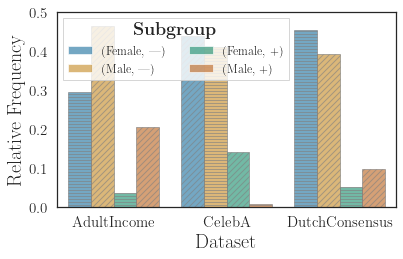

In [941]:
plt.rcParams.update({'hatch.color': 'k'})
sns.set_palette("colorblind")

ax=plt.gca()
bar=sns.barplot(
    x='Data',
    y='Traing Sample Proportions', hue='Subgroup',# kind='bar',
    data=data_sizes,
#     pd.melt(data_sizes.reset_index(), id_vars=['Data', 'Label','Gender'], value_vars=['Train','Test'],
#         var_name='Split', value_name='Sample Size'), 
    alpha=0.6,
ax=ax
)
hatches = ['-', '\\', '-', '\\',
           '-', '\\', '-', '\\',
           '-', '\\', '-', '\\',
          ]
patch_idx = np.argsort([b.xy[0] for b in bar.patches])
for i in patch_idx: 
    # Set a different hatch for each bar
    thisbar = bar.patches[i]
    thisbar.set_hatch('----' if i % 2 == 0 else '////', )
    thisbar.set_edgecolor([0.5,0.5,0.5])


ax.set_xlabel(r"Dataset")
ax.set_ylabel(r"Relative Frequency")
ax.set_ylim([0, 0.5])
sns.move_legend(ax,loc=2,ncol=2,fontsize=12,title_fontsize=18,title=r'$\textbf{Subgroup}$', fancybox=False)
plt.tight_layout()
plt.savefig('./figs/teaser_hist'+'.png', bbox_inches='tight')
plt.savefig('./figs/teaser_hist'+'.pdf', bbox_inches='tight')

#### Table 3

In [1107]:
pd.options.display.float_format = '{:.2}'.format
data_sizes = (  pd.concat([celeba_sizes, adult_sizes,dutch_sizes])
 .sort_values(['Data', 'Label','Gender'])
 .set_index(['Data', 'Label','Gender'])
)

In [1110]:
data_sizes.T

Data   AdultIncome                     CelebA                      \
Label          0.0           1.0          0.0           1.0         
Gender      Female   Male Female  Male Female   Male Female  Male   
Train         9592  15128   1179  6662  71629  66874  22880  1387   
Test          4831   7604    590  3256   9767   7535   2480   180   

Data   DutchConsensus                       
Label             0.0           1.0         
Gender         Female   Male Female   Male  
Train           69117  59608   7991  15064  
Test            17231  15006   1912   3796

In [1111]:
print(data_sizes.T
 .to_latex(multicolumn_format='c',escape=False)
)

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Data & \multicolumn{4}{c}{AdultIncome} & \multicolumn{4}{c}{CelebA} & \multicolumn{4}{c}{DutchConsensus} \\
Label & \multicolumn{2}{c}{0.0} & \multicolumn{2}{c}{1.0} & \multicolumn{2}{c}{0.0} & \multicolumn{2}{c}{1.0} & \multicolumn{2}{c}{0.0} & \multicolumn{2}{c}{1.0} \\
Gender &      Female &   Male & Female &  Male & Female &   Male & Female &  Male &         Female &   Male & Female &   Male \\
\midrule
Train &        9592 &  15128 &   1179 &  6662 &  71629 &  66874 &  22880 &  1387 &          69117 &  59608 &   7991 &  15064 \\
Test  &        4831 &   7604 &    590 &  3256 &   9767 &   7535 &   2480 &   180 &          17231 &  15006 &   1912 &   3796 \\
\bottomrule
\end{tabular}



## Adult Income

In [1171]:
pd.options.display.float_format = '{:.5%}'.format

#### Table 5

In [1169]:
income_gs_eo_df = process_table(income_gs_sweeps_df, method_suffix='', 
                             show_gap=False,
                             tuple_header='EO',
                             constraint='eo'
                            )
income_gs_dp_df = process_table(income_gs_sweeps_df, method_suffix='', 
                             show_gap=False,
                             tuple_header='DP',
                             constraint='dp'
                            )

In [1172]:
pd.concat([income_gs_eo_df,income_gs_dp_df],axis=1)

EO                               \
                              Combined Loss           Fairness Violation   
                                      Train      Test              Train   
$\epsilon$            Method                                               
\multirow{2}{*}{0.01} FIFA        14.77618% 14.93573%           8.53851%   
                      Vanilla     16.68724% 17.28659%          10.39000%   
\multirow{2}{*}{0.05} FIFA        14.79263% 14.91599%           8.57436%   
                      Vanilla     16.68724% 17.28659%          10.39000%   
\multirow{2}{*}{0.10} FIFA        14.70959% 14.88935%           8.17597%   
                      Vanilla     16.68724% 17.28659%          10.39000%   

                                                   DP            \
                                        Combined Loss             
                                   Test         Train      Test   
$\epsilon$            Method                                      
\multirow{2}{*}{0.01} FIFA     8.50086%     13.75700% 14.05881%   
                      Vanilla 10.92794%     14.83347% 15.09909%   
\multirow{2}{*}{0.05} FIFA     8.50841%     13.74952% 14.03440%   
                      Vanilla 10.92794%     14.83475% 15.09909%   
\multirow{2}{*}{0.10} FIFA     8.16283%     13.72278% 14.03193%   
                      Vanilla 10.92794%     14.82782% 15.09909%   

                                                           
                              Fairness Violation           
                                           Train     Test  
$\epsilon$            Method                               
\multirow{2}{*}{0.01} FIFA              0.08609% 0.00999%  
                      Vanilla           3.32436% 3.65903%  
\multirow{2}{*}{0.05} FIFA              0.11811% 0.01008%  
                      Vanilla           3.32895% 3.65903%  
\multirow{2}{*}{0.10} FIFA              0.11331% 0.01011%  
                      Vanilla           3.31507% 3.65903%

In [1173]:
print(
    pd.concat([income_gs_eo_df,income_gs_dp_df],axis=1).to_latex( multicolumn_format='c',escape=False)
)

\begin{tabular}{llrrrrrrrr}
\toprule
                      &         & \multicolumn{4}{c}{EO} & \multicolumn{4}{c}{DP} \\
                      &         & \multicolumn{2}{c}{Combined Loss} & \multicolumn{2}{c}{Fairness Violation} & \multicolumn{2}{c}{Combined Loss} & \multicolumn{2}{c}{Fairness Violation} \\
                      &         &         Train &      Test &              Train &      Test &         Train &      Test &              Train &     Test \\
$\epsilon$ & Method &               &           &                    &           &               &           &                    &          \\
\midrule
\multirow{2}{*}{0.01} & FIFA &     14.77618% & 14.93573% &           8.53851% &  8.50086% &     13.75700% & 14.05881% &           0.08609% & 0.00999% \\
                      & Vanilla &     16.68724% & 17.28659% &          10.39000% & 10.92794% &     14.83347% & 15.09909% &           3.32436% & 3.65903% \\
\multirow{2}{*}{0.05} & FIFA &     14.79263% & 14.91599% &           8.

#### Table 2

In [773]:
income_gs_sweeps_df = pd.read_csv("./csv_data/income_grid_search.csv",)
income_eg_sweeps_df = pd.read_csv("./csv_data/income_expgrad.csv",)

income_gs_sweeps_df['loss_type'] = income_gs_sweeps_df['loss_type'].apply(lambda s : 'standard' if s == 'standard' else 'fdam')
income_eg_sweeps_df['loss_type'] = income_eg_sweeps_df['loss_type'].apply(lambda s : 'standard' if s == 'standard' else 'fdam')

In [774]:
dutch_eg_sweeps_df = pd.read_csv("./csv_data/dutch_expgrad.csv", )
dutch_eg_sweeps_df['loss_type'] = dutch_eg_sweeps_df['loss_type'].apply(lambda s : 'standard' if s == 'standard' else 'fdam')

In [775]:
income_eg_df = process_table(income_eg_sweeps_df, method_suffix='', 
                             show_gap=False,
                             tuple_header='AdultIncome'
                            )
ducth_eg_df = process_table(dutch_eg_sweeps_df, method_suffix='', 
                             show_gap=False,
                             tuple_header='DutchConsensus'
                            )

In [776]:
expg_df = pd.concat([income_eg_df,ducth_eg_df],axis=1)

In [790]:
expg_df

AdultIncome                               \
                              Combined Loss           Fairness Violation   
                                      Train      Test              Train   
$\epsilon$            Method                                               
\multirow{2}{*}{0.01} FIFA        15.72170% 13.48116%           7.88627%   
                      Vanilla     13.95614% 14.30009%           6.78607%   
\multirow{2}{*}{0.05} FIFA        13.56342% 13.54908%           5.70877%   
                      Vanilla     14.46966% 14.86473%           7.59619%   
\multirow{2}{*}{0.10} FIFA        13.58569% 13.90430%           6.12168%   
                      Vanilla     15.53416% 15.93873%           9.75137%   

                                        DutchConsensus            \
                                         Combined Loss             
                                   Test          Train      Test   
$\epsilon$            Method                                       
\multirow{2}{*}{0.01} FIFA     2.77756%      12.80131% 13.16857%   
                      Vanilla  6.74747%      12.84442% 13.22665%   
\multirow{2}{*}{0.05} FIFA     4.93145%      12.88197% 13.22278%   
                      Vanilla  7.85747%      12.88178% 13.22355%   
\multirow{2}{*}{0.10} FIFA     5.96891%      12.87168% 13.17477%   
                      Vanilla 10.07504%      12.87569% 13.20988%   

                                                           
                              Fairness Violation           
                                           Train     Test  
$\epsilon$            Method                               
\multirow{2}{*}{0.01} FIFA              3.72201% 4.35324%  
                      Vanilla           3.79351% 4.43227%  
\multirow{2}{*}{0.05} FIFA              3.85249% 4.43227%  
                      Vanilla           3.85249% 4.43227%  
\multirow{2}{*}{0.10} FIFA              3.83258% 4.35324%  
                      Vanilla           3.83921% 4.40593%

In [780]:
print(
    expg_df.to_latex( multicolumn_format='c', escape=False)
)

\begin{tabular}{llrrrrrrrr}
\toprule
                      &         & \multicolumn{4}{c}{AdultIncome} & \multicolumn{4}{c}{DutchConsensus} \\
                      &         & \multicolumn{2}{c}{Combined Loss} & \multicolumn{2}{c}{Fairness Violation} & \multicolumn{2}{c}{Combined Loss} & \multicolumn{2}{c}{Fairness Violation} \\
                      &         &         Train &     Test &              Train &     Test &          Train &     Test &              Train &    Test \\
$\epsilon$ & Method &               &          &                    &          &                &          &                    &         \\
\midrule
\multirow{2}{*}{0.01} & FIFA &      15.7217% & 13.4812% &            7.8863% &  2.7776% &       12.8013% & 13.1686% &            3.7220% & 4.3532% \\
                      & Vanilla &      13.9561% & 14.3001% &            6.7861% &  6.7475% &       12.8444% & 13.2267% &            3.7935% & 4.4323% \\
\multirow{2}{*}{0.05} & FIFA &      13.5634% & 13.5491% &     

## CelebaA

In [1117]:
pd.options.display.float_format = '{:.2%}'.format

In [1113]:
bld_sweeps_df=pd.read_csv("./csv_data/blond_grid_search.csv")
bld_rep_sweeps_df = pd.read_csv("./csv_data/blond_grid_search_best_repeated.csv")


#### Table 1

In [1121]:
bld_eo_df = process_table(pd.concat([bld_sweeps_df,bld_rep_sweeps_df]), method_suffix='-GS', use_drw=0, 
                             show_gap=True,
                             tuple_header=None,
                          constraint='eo'
                            )

In [711]:
print(
    bld_eo_df.T.to_latex( multicolumn_format='c')
)

\begin{tabular}{llrrrrrrrrr}
\toprule
               & \$\textbackslash epsilon\$ & \multicolumn{3}{c}{\textbackslash multirow\{3\}\{*\}\{0.01\}} & \multicolumn{3}{c}{\textbackslash multirow\{3\}\{*\}\{0.05\}} & \multicolumn{3}{c}{\textbackslash multirow\{3\}\{*\}\{0.10\}} \\
               & Method &               FIFA-GS & LDAM-GS & Vanilla-GS &               FIFA-GS & LDAM-GS & Vanilla-GS &               FIFA-GS & LDAM-GS & Vanilla-GS \\
\midrule
Combined Loss & Train &                 7.37\% &   5.22\% &      7.14\% &                 5.46\% &   5.47\% &      8.84\% &                 5.92\% &   8.48\% &      8.90\% \\
               & Test &                 6.71\% &   7.29\% &     14.01\% &                 6.34\% &   7.38\% &     13.05\% &                 6.54\% &   7.34\% &     16.71\% \\
               & Gap &                 0.66\% &   2.07\% &      6.87\% &                 0.88\% &   1.91\% &      4.21\% &                 0.62\% &   1.14\% &      7.82\% \\
Fairness Violation & T

#### Table 4

In [1151]:
bld_all_sweeps = pd.concat([bld_sweeps_df,bld_rep_sweeps_df])
# grouping all experiments correspond to FIFA
bld_all_sweeps['loss_type'] = bld_all_sweeps['loss_type'].apply(lambda s : 'standard' if s == 'standard' else 'fdam')


In [1162]:
bld_eo_df = process_table(bld_all_sweeps, method_suffix='', use_drw=0, 
                          constraint='eo',
                             show_gap=False,
                             tuple_header='EO',
                            )

In [1163]:
bld_dp_df = process_table(bld_all_sweeps, method_suffix='', use_drw=0, 
                             show_gap=False,
                             tuple_header='DP',
                          constraint='dp',

                            )

In [1164]:
pd.concat([bld_eo_df,bld_dp_df],axis=1)

EO                                   \
                              Combined Loss        Fairness Violation          
                                      Train   Test              Train   Test   
$\epsilon$            Method                                                   
\multirow{2}{*}{0.01} FIFA            7.37%  6.71%              5.31%  2.75%   
                      Vanilla         7.14% 14.01%              6.69% 20.29%   
\multirow{2}{*}{0.05} FIFA            5.46%  6.34%              2.63%  3.29%   
                      Vanilla         8.84% 13.05%              9.45% 17.92%   
\multirow{2}{*}{0.10} FIFA            5.92%  6.54%              3.11%  2.65%   
                      Vanilla         8.90% 16.71%             11.37% 26.15%   

                                         DP                                  
                              Combined Loss        Fairness Violation        
                                      Train   Test              Train  Test  
$\epsilon$            Method                                                 
\multirow{2}{*}{0.01} FIFA            8.65%  7.21%              4.84% 1.45%  
                      Vanilla        10.74% 10.43%              4.72% 1.35%  
\multirow{2}{*}{0.05} FIFA           10.02%  9.40%              4.73% 1.07%  
                      Vanilla        12.14% 11.60%              8.34% 5.17%  
\multirow{2}{*}{0.10} FIFA            9.04%  8.32%              2.98% 0.04%  
                      Vanilla        12.13% 11.66%              9.77% 6.83%

In [1165]:
print(
    pd.concat([bld_eo_df,bld_dp_df],axis=1).to_latex( multicolumn_format='c',escape=False)
)

\begin{tabular}{llrrrrrrrr}
\toprule
                      &         & \multicolumn{4}{c}{EO} & \multicolumn{4}{c}{DP} \\
                      &         & \multicolumn{2}{c}{Combined Loss} & \multicolumn{2}{c}{Fairness Violation} & \multicolumn{2}{c}{Combined Loss} & \multicolumn{2}{c}{Fairness Violation} \\
                      &         &         Train &   Test &              Train &   Test &         Train &   Test &              Train &  Test \\
$\epsilon$ & Method &               &        &                    &        &               &        &                    &       \\
\midrule
\multirow{2}{*}{0.01} & FIFA &         7.37% &  6.71% &              5.31% &  2.75% &         8.65% &  7.21% &              4.84% & 1.45% \\
                      & Vanilla &         7.14% & 14.01% &              6.69% & 20.29% &        10.74% & 10.43% &              4.72% & 1.35% \\
\multirow{2}{*}{0.05} & FIFA &         5.46% &  6.34% &              2.63% &  3.29% &        10.02% &  9.40% &         

## Plots

In [290]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt


sns.set()
sns.set(font_scale=1.5,)
sns.set_style("white")
sns.set_style({'font.family': 'Times New Roman'})
sns.set_palette("colorblind")


plt.rcParams.update({'font.size': 20, 'lines.linewidth':4, 'lines.markersize':12, 
                         'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':20,
                         'axes.titlesize': 20, 'legend.fontsize':20,
                         'pdf.fonttype': 42, 'ps.fonttype':42,
                        'image.interpolation':'nearest', 'figure.figsize': (6,4),
                     'text.usetex': True
                     
                    })
tqdm.tqdm.pandas()
# logging.getLogger().setLevel(logging.CRITICAL)

### Table 4: Covergage of $C$

In [ ]:
eo_C_df=(show_agg_df(bld_sweeps_df,added_cols=['max_m'])
 .query("constraint=='eo'").query("use_drw==0").query('loss_type!="standard"')
 .reset_index()
 [['constraint', 'violation_eps', 'loss_type', 'max_m']]
)

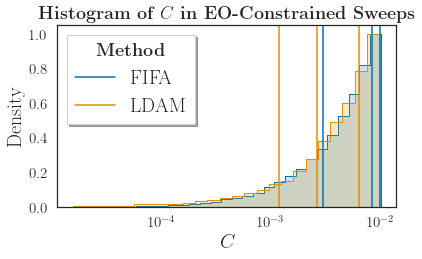

In [781]:
ax=plt.gca()



sns.histplot(data=(bld_sweeps_df.drop_duplicates('exp_id')
                   .query("constraint=='eo'")
                   .query("loss_type=='fdam'").reset_index()
                  ),
             x='max_m',
             stat='density',
             color='C0',
             bins=25,
             log_scale=(True, False),
             element='step',cumulative=True,
             alpha=0.2,

             ax=ax)

sns.histplot(data=(bld_sweeps_df.drop_duplicates('exp_id')
                   .query("constraint=='eo'")
                   .query("loss_type=='ldam'").reset_index()
                  ),
             x='max_m',
             stat='density',
             color='C1',
             bins=25,
             log_scale=(True, False),
             element='step',cumulative=True,
             alpha=0.2,
             ax=ax)
for rid, row in eo_C_df.iterrows():

    ax.axvline(x=row['max_m'], ymin=0., ymax = 1.5, linewidth=1.5, color=f"C{0 if row['loss_type']=='fdam' else 1}")


ax.set_xlabel(r'$C$')
ax.legend(title=r'\textbf{Method}', loc='upper left', labels=['FIFA', 'LDAM'], fancybox=False, shadow=True)
plt.title(r"\textbf{Histogram of $C$ in EO-Constrained Sweeps}", fontsize=18)
plt.tight_layout()
plt.savefig('./figs/C_histogram.png', bbox_inches='tight')
plt.savefig('./figs/C_histogram.pdf', bbox_inches='tight')
# ax.set_ylabel(r'Combined Loss Generalization Gap')

In [707]:
(rep_df.query('violation_eps==0.05').query('loss_type=="ldam"')[['loss_type',
                                                                  'train_balanced_loss',
                                                                 'test_balanced_loss', 
                                                                 'bal_loss_gap',
                                                                 'train_violation',
                                                                 'test_violation',
                                                                 'violation_gap']]
 .query('test_balanced_loss < 0.0798')
#  .sort_values('test_balanced_loss')
)

,loss_type,train_balanced_loss,test_balanced_loss,bal_loss_gap,train_violation,test_violation,violation_gap
157,ldam,5.47%,7.38%,1.91%,2.57%,5.57%,3.00%


### Figure 6: CelebA Generalization

In [791]:
rep_df = (bld_rep_sweeps_df
    .query("loss_type != 'ldam'")
    .rename({'test_balloss_cls_eo': 'test_balanced_loss',
              'train_balloss_cls_eo': 'train_balanced_loss',
              'test_eo': 'test_violation',
              'train_eo': 'train_violation'
             },axis=1)         
    .assign(bal_acc_gap=lambda x :  x['train_cls_avg_acc'] - x['test_cls_avg_acc'] )
    .assign(bal_loss_gap=lambda x :  x['test_balanced_loss'] - x['train_balanced_loss'] )
    .assign(violation_gap=lambda x :  x['test_violation'] - x['train_violation'] )

)

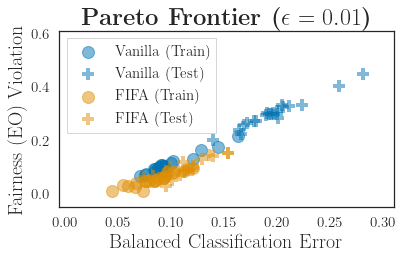

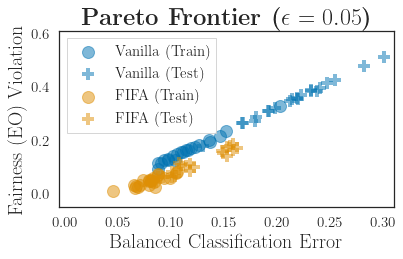

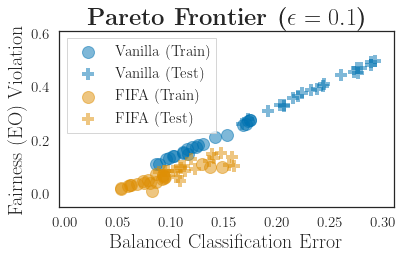

In [782]:
for eps in [0.01, 0.05, 0.1]:
    plt.figure()
    ax = plt.gca()
    for ls_idx, ls in enumerate(['standard', 'fdam']):
        plt_dt = rep_df.query(rf"violation_eps=={eps}").query(rf"loss_type=='{ls}'").reset_index()
        plt.scatter(plt_dt['train_balanced_loss'].values, plt_dt['train_violation'].values, 
                label=rf'{["Vanilla", "FIFA"][ls_idx]} (Train)',
                alpha=0.5,
               color=f"C{ls_idx}",
                   )
        plt.scatter(plt_dt['test_balanced_loss'].values, plt_dt['test_violation'].values, 
                label=rf'{["Vanilla", "FIFA"][ls_idx]} (Test)',
                alpha=0.5,
               color=f"C{ls_idx}", marker='+',
                   )
    ax.legend(ncol=1, fontsize=15, fancybox=False)
    
    ax.set_xlim(-0.005, 0.31)
    ax.set_ylim(-0.05,0.61)

    ax.set_xlabel(r"Balanced Classification Error")
    ax.set_ylabel(r"Fairness (EO) Violation")

    ax.set_title(r"\textbf{Pareto Frontier ($\epsilon={"+f"{eps}"+r"}$)}", fontsize=24)
    plt.tight_layout()
    plt.savefig('./figs/pareto_'+f'{eps}'+'.png', bbox_inches='tight')
    plt.savefig('./figs/pareto_'+f'{eps}'+'.pdf', bbox_inches='tight')

### Figure 5

In [792]:
def viz_gap(data, col, title, ylabel='Generalization Gap', filename=None):
    ax = plt.gca()
    sns.lineplot(data=rep_df.reset_index(),
                 x='violation_eps', 
                 y=col,
                 hue='loss_type',
                 style='loss_type',
                 ci=95,
                 err_style="bars",
                 ax=ax
                )
    ax.set_xlabel(r'$\epsilon$')
    ax.set_ylabel(rf'{ylabel}')
    ax.legend(title=r'\textbf{Method}', loc='upper right', labels=['Vanilla', 'FIFA'], fancybox=False, shadow=False)
    plt.title(r'\textbf{'+title+'}', fontsize=18)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename+'.png', bbox_inches='tight')
        plt.savefig(filename+'.pdf', bbox_inches='tight')

    

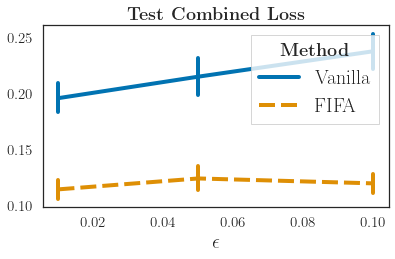

In [793]:
viz_gap(rep_df, 'test_balanced_loss', title='Test Combined Loss', ylabel='', filename='./figs/blond_test_comb_loss')

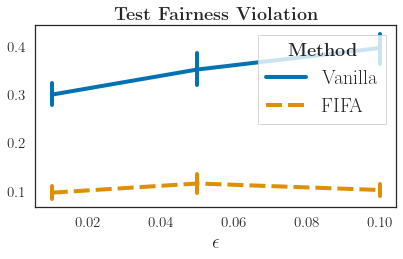

In [794]:
viz_gap(rep_df, 'test_violation', title='Test Fairness Violation', ylabel='', filename='./figs/blond_test_fair')

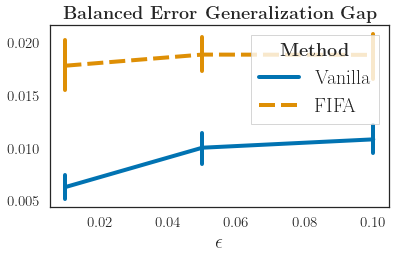

In [795]:
viz_gap(rep_df, 'bal_acc_gap', 'Balanced Error Generalization Gap', ylabel='', filename='./figs/blond_bal_err_gap')

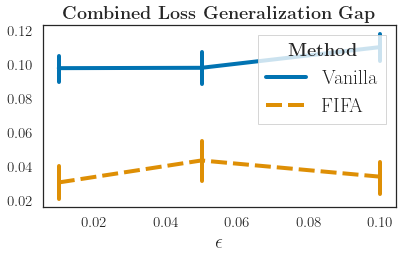

In [796]:
viz_gap(rep_df, 'bal_loss_gap', 'Combined Loss Generalization Gap', ylabel='', filename='./figs/blond_comb_gap')

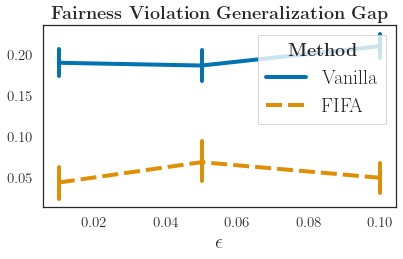

In [797]:
viz_gap(rep_df, 'violation_gap', 'Fairness Violation Generalization Gap', ylabel='', filename='./figs/blond_fair_gap')

### Figure 1: Teaser

In [489]:
import matplotlib.patches

teaser_df = pd.read_csv('./csv_data/celeba_gen.csv',)
teaser_df = teaser_df[teaser_df._step == teaser_df.groupby('train.eps')._step.transform('max')].reset_index()

In [490]:
treaser_tr = teaser_df[['exp_id','train.eps', 'train.eo', 'train.err']].copy().rename({
    'train.eps': 'eps',
    'train.eo': 'EO Violation',
    'train.err': 'Classification Error'
},axis=1)
treaser_tr['Data'] = 'Train'
treaser_te = teaser_df[['exp_id','train.eps', 'test.eo', 'test.err']].copy().rename({
    'train.eps': 'eps',
    'test.eo': 'EO Violation',
    'test.err': 'Classification Error'
},axis=1)
treaser_te['Data'] = 'Test'

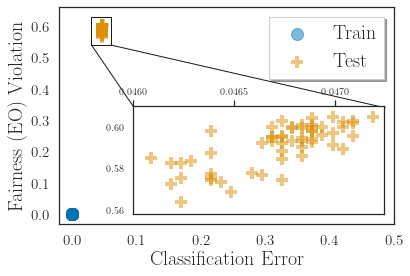

In [845]:
fig = plt.figure()
ax = plt.gca()
plt.scatter(treaser_tr['Classification Error'].values, treaser_tr['EO Violation'].values, 
            label=r'Train',alpha=0.5, marker='o',
           color='C0')
plt.scatter(treaser_te['Classification Error'].values, treaser_te['EO Violation'].values, 
            label=r'Test',alpha=0.5, marker='+',
           color='C1')
ax.legend(loc=1, #bbox_to_anchor=(0.5, -0.05),
          fancybox=False, shadow=True, 
          ncol=1)
ax.set_xlim(-0.02,0.5)


ax.set_xlabel(r"Classification Error")
ax.set_ylabel(r"Fairness (EO) Violation")
rect = matplotlib.patches.Rectangle((0.03, 0.54), 0.03, 0.09, linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

plt.plot([0.03, 0.096], [0.54, 0.341], 'k-', lw=1)
plt.plot([0.06, 0.48618], [0.54, 0.34], 'k-', lw=1)

inset_axes = mpl_toolkits.axes_grid.inset_locator.inset_axes(ax, 
                    width="75%", # width = 30% of parent_bbox
                    height=1.5, # height : 1 inch
                    loc=4)
inset_axes.scatter(treaser_te['Classification Error'].values, treaser_te['EO Violation'].values, 
            label=r'Test',alpha=0.5, marker='+',
           color='C1')
inset_axes.set_ylim([0.558,0.61])
inset_axes.set_yticks([0.56,0.58,0.60])
inset_axes.set_xticks([0.046, 0.0465, 0.047])
inset_axes.xaxis.tick_top()
inset_axes.tick_params(axis="both",labelsize=10)



# plt.tight_layout()
plt.savefig('./figs/teaser'+'.png', bbox_inches='tight')
plt.savefig('./figs/teaser'+'.pdf', bbox_inches='tight')

## Figure 7: Trajectory

In [1079]:
def viz_traj(data, col, col_name, legend_loc=2, filename=None):
    ax = plt.gca()
    dt = (data.melt(id_vars=['exp_id','n_iters', 'loss_type'],
                   value_vars=['train_'+col, 'test_'+col],
        var_name='Split', value_name=col_name)
          .rename({'loss_type':'Method'},axis=1)
          .replace({'Split':{
              'train_'+col:'Train',
              'test_'+col: 'Test'
          },  'Method': {
              'standard':'Vanilla',
              'fdam':'FIFA',
          }
                   })
         )
    sns.lineplot(data=dt.reset_index(),
                 x='n_iters', 
                 y=col_name,
                 hue='Method',
                 style='Split',
                 hue_order=['Vanilla','FIFA'],
                 ci=95,
                 err_style="bars",
                 ax=ax,
                 lw=3,err_kws={'lw':1.5}
                )
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(col_name)
    ax.set_xscale('log')
#     ax.legend(title=r'\textbf{Method}', loc='upper right', labels=['Vanilla', 'FIFA'], fancybox=False, shadow=False)
    sns.move_legend(ax, legend_loc, ncol=2,fancybox=False, fontsize=14, title_fontsize=18)
#     plt.title(r'\textbf{'+title+'}', fontsize=18)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename+'.png', bbox_inches='tight')
        plt.savefig(filename+'.pdf', bbox_inches='tight')

    

In [1080]:
traj_sweeps_df = pd.read_csv("./csv_data/trajectory.csv", )
traj_sweeps_df['train_bal_err']=1. - traj_sweeps_df['train_cls_avg_acc']
traj_sweeps_df['test_bal_err']=1. - traj_sweeps_df['test_cls_avg_acc']

In [1089]:
traj_sweeps_df.loc[traj_sweeps_df._step==0, '_step']=1

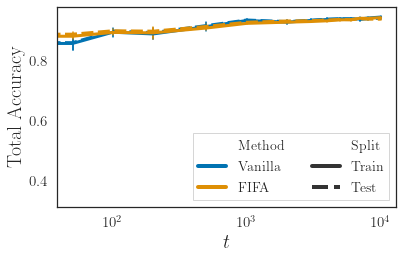

In [1091]:
viz_traj(traj_sweeps_df, 'acc', 'Total Accuracy', legend_loc=4, filename='./figs/traj_total_acc')

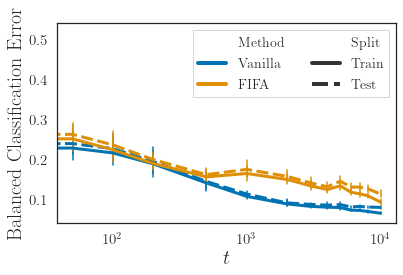

In [1092]:
viz_traj(traj_sweeps_df, 'bal_err', 'Balanced Classification Error', legend_loc=1, filename='./figs/traj_bal_err')

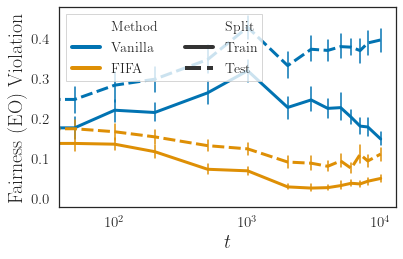

In [1093]:
viz_traj(traj_sweeps_df, 'eo', 'Fairness (EO) Violation', legend_loc=2, filename='./figs/traj_eo')

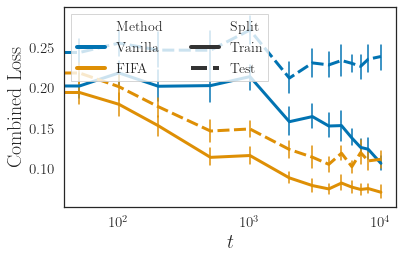

In [1094]:
viz_traj(traj_sweeps_df, 'balloss_cls_eo', 'Combined Loss', legend_loc=2, filename='./figs/traj_comb')